In [ ]:
pip install ultralytics

from architecture import * 
import os 
import cv2
import mtcnn
import pickle 
import numpy as np 
from sklearn.preprocessing import Normalizer
from tensorflow.keras.models import load_model

######pathsandvairables#########
face_data = 'Faces/'
required_shape = (160,160)
face_encoder = InceptionResNetV2()
path = "facenet_keras_weights.h5"
face_encoder.load_weights(path)
face_detector = mtcnn.MTCNN()
encodes = []
encoding_dict = dict()
l2_normalizer = Normalizer('l2')
###############################


def normalize(img):
    mean, std = img.mean(), img.std()
    return (img - mean) / std


for face_names in os.listdir(face_data):
    person_dir = os.path.join(face_data,face_names)

    for image_name in os.listdir(person_dir):
        image_path = os.path.join(person_dir,image_name)

        img_BGR = cv2.imread(image_path)
        img_RGB = cv2.cvtColor(img_BGR, cv2.COLOR_BGR2RGB)

        x = face_detector.detect_faces(img_RGB)
        x1, y1, width, height = x[0]['box']
        x1, y1 = abs(x1) , abs(y1)
        x2, y2 = x1+width , y1+height
        face = img_RGB[y1:y2 , x1:x2]
        
        face = normalize(face)
        face = cv2.resize(face, required_shape)
        face_d = np.expand_dims(face, axis=0)
        encode = face_encoder.predict(face_d)[0]
        encodes.append(encode)

    if encodes:
        encode = np.sum(encodes, axis=0 )
        encode = l2_normalizer.transform(np.expand_dims(encode, axis=0))[0]
        encoding_dict[face_names] = encode
    
path = 'encodings/encodings.pkl'
with open(path, 'wb') as file:
    pickle.dump(encoding_dict, file)








import cv2
import numpy as np
import mtcnn
from architecture import *
from train_v2 import normalize, l2_normalizer
from scipy.spatial.distance import cosine
from tensorflow.keras.models import load_model
import pickle

confidence_t = 0.99
recognition_t = 0.5
required_size = (160, 160)

def get_face(img, box):
    x1, y1, width, height = box
    x1, y1 = abs(x1), abs(y1)
    x2, y2 = x1 + width, y1 + height
    face = img[y1:y2, x1:x2]
    return face, (x1, y1), (x2, y2)

def get_encode(face_encoder, face, size):
    face = normalize(face)
    face = cv2.resize(face, size)
    encode = face_encoder.predict(np.expand_dims(face, axis=0))[0]
    return encode

def load_pickle(path):
    with open(path, 'rb') as f:
        encoding_dict = pickle.load(f)
    return encoding_dict

def detect(img, detector, encoder, encoding_dict):
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    results = detector.detect_faces(img_rgb)
    for res in results:
        if res['confidence'] < confidence_t:
            continue
        face, pt_1, pt_2 = get_face(img_rgb, res['box'])
        encode = get_encode(encoder, face, required_size)
        encode = l2_normalizer.transform(encode.reshape(1, -1))[0]
        name = 'unknown'

        distance = float("inf")
        for db_name, db_encode in encoding_dict.items():
            dist = cosine(db_encode, encode)
            if dist < recognition_t and dist < distance:
                name = db_name
                distance = dist

        if name == 'unknown':
            cv2.rectangle(img, pt_1, pt_2, (0, 0, 255), 2)
            cv2.putText(img, name, pt_1, cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 1)
        else:
            cv2.rectangle(img, pt_1, pt_2, (0, 255, 0), 2)
            cv2.putText(img, name + f'__{distance:.2f}', (pt_1[0], pt_1[1] - 5), cv2.FONT_HERSHEY_SIMPLEX, 1,
                        (0, 200, 200), 2)
    return img

if __name__ == "__main__":
    required_shape = (160, 160)
    face_encoder = InceptionResNetV2()
    path_m = "facenet_keras_weights.h5"
    face_encoder.load_weights(path_m)
    encodings_path = 'encodings/encodings.pkl'
    face_detector = mtcnn.MTCNN()
    encoding_dict = load_pickle(encodings_path)

    # Load the image
    image_path = 'test/asd.jpg'  # Replace with the path to your image
    image = cv2.imread(image_path)

    # Perform face detection and recognition on the image
    result_image = detect(image, face_detector, face_encoder, encoding_dict)

    # Save the result image
    output_image_path = 'o7.jpg'  # Specify the output image path
    cv2.imwrite(output_image_path, result_image)

    # Display the result image in a smaller window
    scaled_image = cv2.resize(result_image, (800, 600))  # Adjust the size as needed
    cv2.imshow('Result', scaled_image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()


In [5]:
!yolo detect predict model=yolov8n.pt source=test.jpg

Ultralytics YOLOv8.0.227 ðŸš€ Python-3.10.0rc2 torch-2.1.2+cpu CPU (12th Gen Intel Core(TM) i7-12700KF)
YOLOv8n summary (fused): 168 layers, 3151904 parameters, 0 gradients, 8.7 GFLOPs

image 1/1 D:\githubrepo\Face Recongnition\recognition\recognition\test.jpg: 384x640 2 backpacks, 1 chair, 1 couch, 1 teddy bear, 46.9ms
Speed: 0.0ms preprocess, 46.9ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)
Results saved to runs\detect\predict
ðŸ’¡ Learn more at https://docs.ultralytics.com/modes/predict


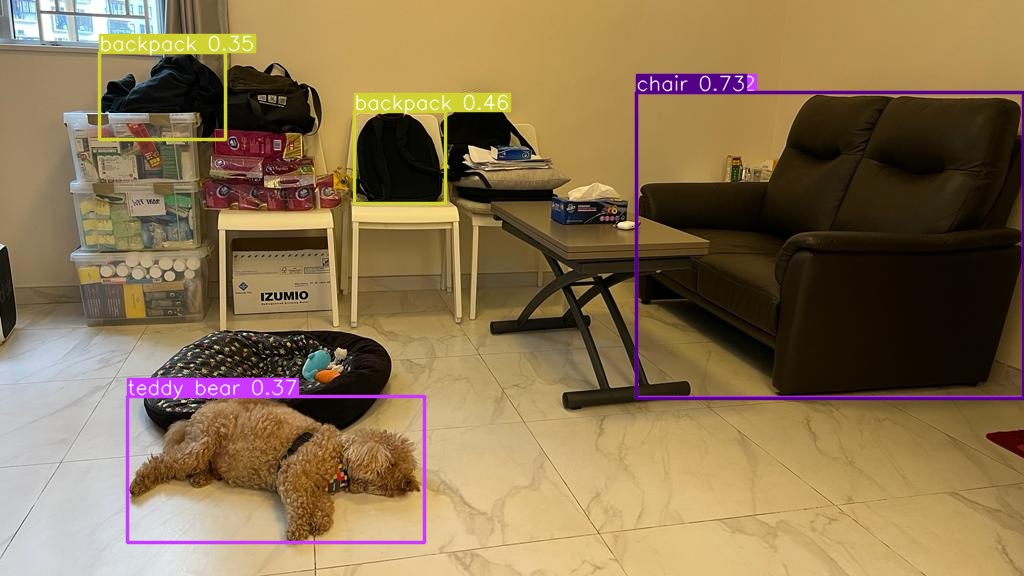

In [7]:
import os
from IPython.display import display, Image, Video

# Set the path to the folder
folder_path = "runs/detect/predict/"

# List all files in the folder
files = os.listdir(folder_path)

# Display each image or video in the folder
for file in files:
    # Check if the file is an image or video
    if file.lower().endswith((".jpg", ".jpeg", ".png", ".avi", ".webp")):
        # Display the image or video
        file_path = os.path.join(folder_path, file)
        if file.lower().endswith((".jpg", ".jpeg", ".png")):
            display(Image(filename=file_path))
        elif file.lower().endswith(".avi"):
            display(Video(file_path))
        elif file.lower().endswith(".webp"):
            # Assuming the IPython library supports WebP format
            display(Image(filename=file_path, format='png'))
